In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


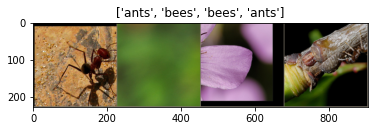

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    Val_loss = []
    Val_Accuracy = []
    Epochs = [i+1 for i in np.arange(num_epochs)]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'val':
              Val_loss.append(epoch_loss)
              Val_Accuracy.append(epoch_acc.cpu())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print('Validation loss v/s epoch plot: ')
    plt.plot(Epochs,Val_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Validation loss')
    plt.show()
    print('Validation accuracy v/s epoch plot: ')
    plt.plot(Epochs,Val_Accuracy)
    plt.xlabel('Epoch')
    plt.ylabel('Validation accuracy')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
import warnings
warnings.filterwarnings("ignore")

Epoch 0/24
----------
train Loss: 0.6383 Acc: 0.6721
val Loss: 0.2548 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4475 Acc: 0.8156
val Loss: 0.3614 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.6019 Acc: 0.7828
val Loss: 0.2905 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4637 Acc: 0.7828
val Loss: 0.2396 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3995 Acc: 0.8361
val Loss: 0.2711 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4479 Acc: 0.8074
val Loss: 0.2039 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.6941 Acc: 0.7418
val Loss: 0.3242 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3765 Acc: 0.8443
val Loss: 0.1903 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3717 Acc: 0.8648
val Loss: 0.1983 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2736 Acc: 0.8811
val Loss: 0.1819 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3178 Acc: 0.8730
val Loss: 0.1823 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3827 Acc: 0.8238
val Loss: 0.1865 Acc: 0.9216

Ep

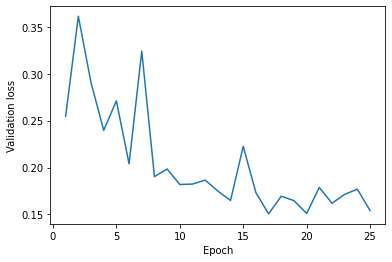

Validation accuracy v/s epoch plot: 


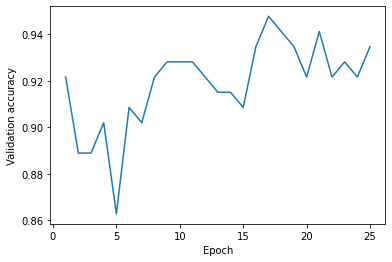

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Here with increasing number of epochs, the net effect on validation loss seems to be decreasing the validation accuracy hence increases.

#d:

For learning rate =  0.01 :
Epoch 0/24
----------
train Loss: 0.6176 Acc: 0.7828
val Loss: 0.9796 Acc: 0.6928

Epoch 1/24
----------
train Loss: 0.7677 Acc: 0.7500
val Loss: 0.2220 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5275 Acc: 0.8033
val Loss: 0.4406 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.6065 Acc: 0.7705
val Loss: 0.4635 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.4969 Acc: 0.8484
val Loss: 0.4210 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4209 Acc: 0.8566
val Loss: 0.3705 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5350 Acc: 0.8033
val Loss: 0.9351 Acc: 0.6993

Epoch 7/24
----------
train Loss: 0.4904 Acc: 0.8484
val Loss: 0.2674 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.4529 Acc: 0.8402
val Loss: 0.2662 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3488 Acc: 0.8525
val Loss: 0.2213 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3299 Acc: 0.8607
val Loss: 0.2185 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2248 Acc: 0.9016
val 

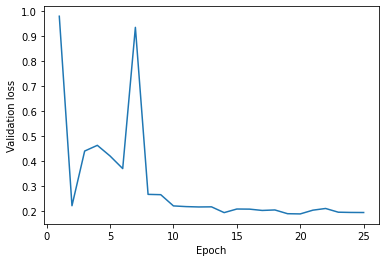

Validation accuracy v/s epoch plot: 


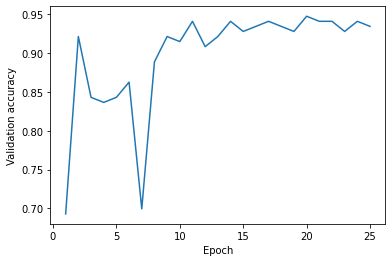

For learning rate =  0.005 :
Epoch 0/24
----------
train Loss: 0.3926 Acc: 0.8279
val Loss: 0.2130 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.3853 Acc: 0.8525
val Loss: 0.3517 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.2736 Acc: 0.8852
val Loss: 0.2873 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.2193 Acc: 0.9016
val Loss: 0.2223 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.1953 Acc: 0.9385
val Loss: 0.1827 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.2520 Acc: 0.9180
val Loss: 0.2102 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.2395 Acc: 0.9139
val Loss: 0.2301 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3050 Acc: 0.9057
val Loss: 0.1979 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3135 Acc: 0.8770
val Loss: 0.2348 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2271 Acc: 0.8934
val Loss: 0.2029 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2635 Acc: 0.9180
val Loss: 0.1996 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.1866 Acc: 0.9016
val

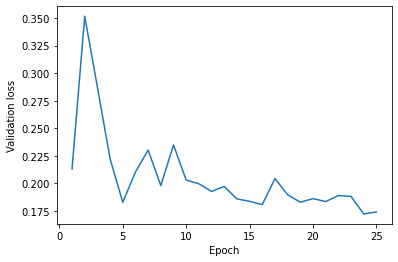

Validation accuracy v/s epoch plot: 


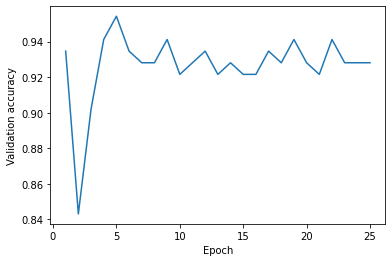

For learning rate =  0.0001 :
Epoch 0/24
----------
train Loss: 0.2705 Acc: 0.8975
val Loss: 0.2207 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.3468 Acc: 0.8566
val Loss: 0.1724 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.3470 Acc: 0.8484
val Loss: 0.1888 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.2376 Acc: 0.8934
val Loss: 0.1843 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2066 Acc: 0.9139
val Loss: 0.1785 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.2726 Acc: 0.8811
val Loss: 0.1711 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.2398 Acc: 0.9098
val Loss: 0.1961 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3647 Acc: 0.8648
val Loss: 0.1701 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.2694 Acc: 0.8770
val Loss: 0.1735 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.2296 Acc: 0.9098
val Loss: 0.1658 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.2640 Acc: 0.9139
val Loss: 0.1742 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3026 Acc: 0.8770
va

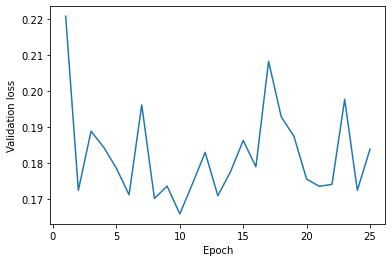

Validation accuracy v/s epoch plot: 


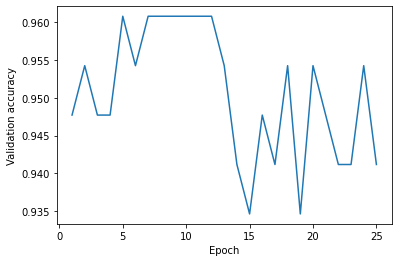

In [17]:
for lr in [0.01,0.005,0.0001]:
  print('For learning rate = ',lr ,':')
  optimizer_ft = optim.SGD(model_ft.parameters(), lr, momentum=0.1)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

With decreasing learning rate, the rate of convrgence also decreases. And we can see that if learning rate is too low, then the validation accuracy sometimes decreases after 25 iterations (As in case of learning rate = 0.005, 0.0001 here).

For Momentum =  0.01 :
Epoch 0/24
----------
train Loss: 0.2171 Acc: 0.9098
val Loss: 0.1873 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.2678 Acc: 0.8934
val Loss: 0.1662 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.2090 Acc: 0.9180
val Loss: 0.1867 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.2366 Acc: 0.9098
val Loss: 0.1836 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.2040 Acc: 0.9221
val Loss: 0.1964 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.1951 Acc: 0.9262
val Loss: 0.1893 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.1912 Acc: 0.9303
val Loss: 0.1750 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.1841 Acc: 0.9221
val Loss: 0.1876 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.2833 Acc: 0.8770
val Loss: 0.1797 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2291 Acc: 0.9057
val Loss: 0.1992 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2671 Acc: 0.8852
val Loss: 0.1846 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2658 Acc: 0.8934
val Loss:

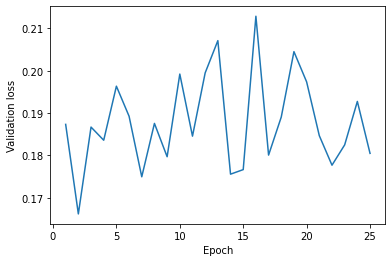

Validation accuracy v/s epoch plot: 


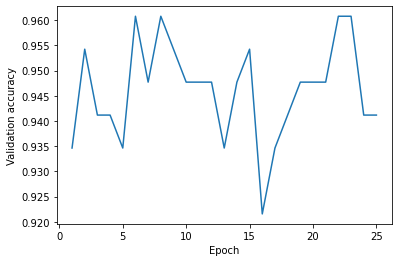

For Momentum =  0.1 :
Epoch 0/24
----------
train Loss: 0.2533 Acc: 0.8852
val Loss: 0.1958 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.1883 Acc: 0.9221
val Loss: 0.1873 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.2835 Acc: 0.8852
val Loss: 0.1828 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.2903 Acc: 0.8893
val Loss: 0.1963 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.2905 Acc: 0.8730
val Loss: 0.1696 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3068 Acc: 0.8648
val Loss: 0.1689 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.1450 Acc: 0.9508
val Loss: 0.1683 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2135 Acc: 0.9057
val Loss: 0.1736 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2640 Acc: 0.8852
val Loss: 0.1699 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.1880 Acc: 0.9057
val Loss: 0.1583 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2463 Acc: 0.9057
val Loss: 0.1660 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3279 Acc: 0.8607
val Loss: 

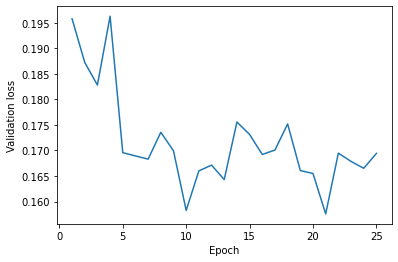

Validation accuracy v/s epoch plot: 


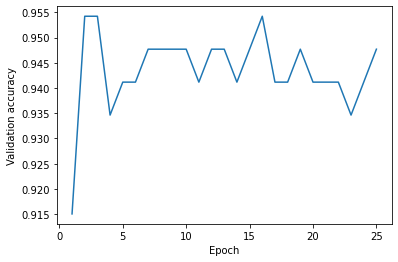

For Momentum =  0.9 :
Epoch 0/24
----------
train Loss: 0.4517 Acc: 0.8156
val Loss: 0.2695 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3755 Acc: 0.8607
val Loss: 0.1908 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.2537 Acc: 0.8975
val Loss: 0.2457 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.2654 Acc: 0.8852
val Loss: 0.3162 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4895 Acc: 0.8197
val Loss: 0.2902 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3935 Acc: 0.8402
val Loss: 0.1599 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4171 Acc: 0.8525
val Loss: 0.6052 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.2524 Acc: 0.8852
val Loss: 0.1949 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2756 Acc: 0.8934
val Loss: 0.2067 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3577 Acc: 0.8648
val Loss: 0.1723 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3014 Acc: 0.8934
val Loss: 0.1972 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2227 Acc: 0.9016
val Loss: 

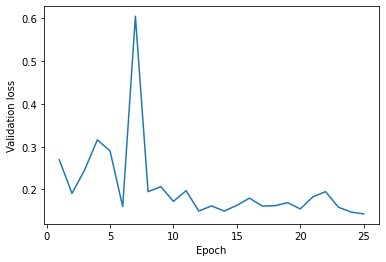

Validation accuracy v/s epoch plot: 


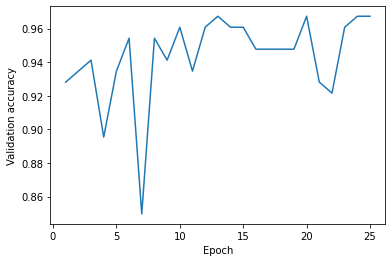

In [18]:
for momentum in [0.01,0.1,0.9]:
  print('For Momentum = ',momentum ,':')
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=momentum)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

When we increase momentum from 0.01 to 0.1, then the net effect on validation accuracy is quite positive, and it increases significantly. The convergence rate is also good for that as compared to when we increase the momentum to 0.9 , but the validation accuracy is higher for momentum = 0.9 

For Number of epochs =  15 :
Epoch 0/14
----------
train Loss: 0.2903 Acc: 0.8811
val Loss: 0.1526 Acc: 0.9608

Epoch 1/14
----------
train Loss: 0.2625 Acc: 0.9098
val Loss: 0.1740 Acc: 0.9346

Epoch 2/14
----------
train Loss: 0.2377 Acc: 0.9139
val Loss: 0.1559 Acc: 0.9412

Epoch 3/14
----------
train Loss: 0.2309 Acc: 0.9098
val Loss: 0.1580 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.2293 Acc: 0.8934
val Loss: 0.1475 Acc: 0.9608

Epoch 5/14
----------
train Loss: 0.1697 Acc: 0.9344
val Loss: 0.1533 Acc: 0.9673

Epoch 6/14
----------
train Loss: 0.3137 Acc: 0.8730
val Loss: 0.1422 Acc: 0.9608

Epoch 7/14
----------
train Loss: 0.2787 Acc: 0.9016
val Loss: 0.1465 Acc: 0.9673

Epoch 8/14
----------
train Loss: 0.2092 Acc: 0.9180
val Loss: 0.1559 Acc: 0.9608

Epoch 9/14
----------
train Loss: 0.2002 Acc: 0.9057
val Loss: 0.1507 Acc: 0.9608

Epoch 10/14
----------
train Loss: 0.2574 Acc: 0.8893
val Loss: 0.1591 Acc: 0.9477

Epoch 11/14
----------
train Loss: 0.2157 Acc: 0.9139
val

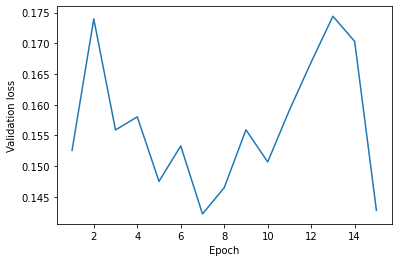

Validation accuracy v/s epoch plot: 


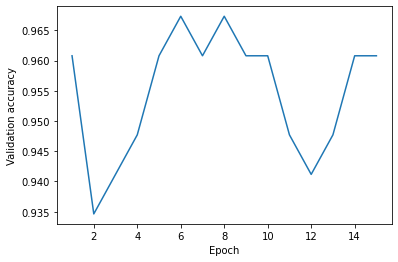

For Number of epochs =  20 :
Epoch 0/19
----------
train Loss: 0.1874 Acc: 0.9016
val Loss: 0.1680 Acc: 0.9542

Epoch 1/19
----------
train Loss: 0.2244 Acc: 0.9016
val Loss: 0.1596 Acc: 0.9673

Epoch 2/19
----------
train Loss: 0.2294 Acc: 0.8934
val Loss: 0.1773 Acc: 0.9412

Epoch 3/19
----------
train Loss: 0.2522 Acc: 0.9057
val Loss: 0.1780 Acc: 0.9412

Epoch 4/19
----------
train Loss: 0.1839 Acc: 0.9180
val Loss: 0.1458 Acc: 0.9608

Epoch 5/19
----------
train Loss: 0.1320 Acc: 0.9508
val Loss: 0.1644 Acc: 0.9346

Epoch 6/19
----------
train Loss: 0.2300 Acc: 0.8934
val Loss: 0.1654 Acc: 0.9346

Epoch 7/19
----------
train Loss: 0.2068 Acc: 0.9139
val Loss: 0.1537 Acc: 0.9542

Epoch 8/19
----------
train Loss: 0.1505 Acc: 0.9549
val Loss: 0.1531 Acc: 0.9608

Epoch 9/19
----------
train Loss: 0.2501 Acc: 0.8893
val Loss: 0.1572 Acc: 0.9412

Epoch 10/19
----------
train Loss: 0.1779 Acc: 0.9221
val Loss: 0.1711 Acc: 0.9542

Epoch 11/19
----------
train Loss: 0.1753 Acc: 0.9303
val

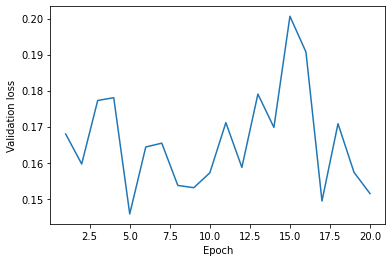

Validation accuracy v/s epoch plot: 


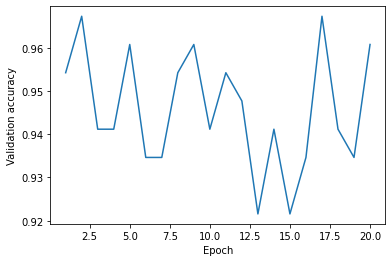

For Number of epochs =  30 :
Epoch 0/29
----------
train Loss: 0.2037 Acc: 0.9180
val Loss: 0.1702 Acc: 0.9542

Epoch 1/29
----------
train Loss: 0.2287 Acc: 0.8852
val Loss: 0.1709 Acc: 0.9477

Epoch 2/29
----------
train Loss: 0.2004 Acc: 0.9098
val Loss: 0.1370 Acc: 0.9673

Epoch 3/29
----------
train Loss: 0.1918 Acc: 0.9098
val Loss: 0.1572 Acc: 0.9542

Epoch 4/29
----------
train Loss: 0.2373 Acc: 0.8893
val Loss: 0.1607 Acc: 0.9542

Epoch 5/29
----------
train Loss: 0.2361 Acc: 0.9016
val Loss: 0.1516 Acc: 0.9477

Epoch 6/29
----------
train Loss: 0.2069 Acc: 0.9262
val Loss: 0.1613 Acc: 0.9542

Epoch 7/29
----------
train Loss: 0.1617 Acc: 0.9303
val Loss: 0.1461 Acc: 0.9608

Epoch 8/29
----------
train Loss: 0.2445 Acc: 0.8852
val Loss: 0.1663 Acc: 0.9542

Epoch 9/29
----------
train Loss: 0.2564 Acc: 0.8975
val Loss: 0.1752 Acc: 0.9542

Epoch 10/29
----------
train Loss: 0.2808 Acc: 0.8648
val Loss: 0.1887 Acc: 0.9150

Epoch 11/29
----------
train Loss: 0.2243 Acc: 0.8852
val

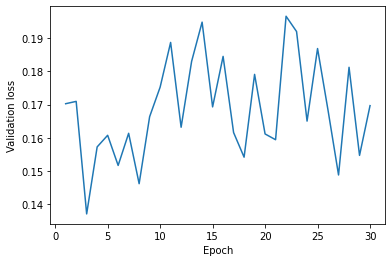

Validation accuracy v/s epoch plot: 


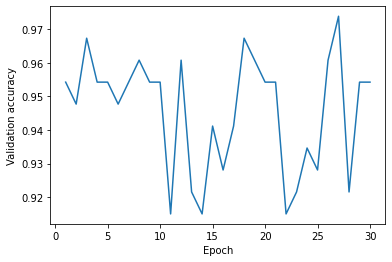

In [19]:
for num_epochs in [15,20,30]: # Running the for loop for changing the number of epochs.
  print('For Number of epochs = ',num_epochs ,':')
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.1)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)

Increasing number of iterations give us more clarity about the behaviour of model in each epoch.

#e:

Epoch 0/24
----------
train Loss: 0.5093 Acc: 0.7705
val Loss: 0.2776 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.8255 Acc: 0.6926
val Loss: 0.3052 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.3558 Acc: 0.8484
val Loss: 0.2517 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3991 Acc: 0.8197
val Loss: 0.3118 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4215 Acc: 0.8279
val Loss: 0.3310 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4419 Acc: 0.8115
val Loss: 0.3156 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.3842 Acc: 0.8443
val Loss: 0.3071 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3346 Acc: 0.8607
val Loss: 0.2469 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.2959 Acc: 0.8811
val Loss: 0.2428 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3810 Acc: 0.8279
val Loss: 0.2185 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3469 Acc: 0.8607
val Loss: 0.2380 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2673 Acc: 0.8811
val Loss: 0.2147 Acc: 0.9150

Ep

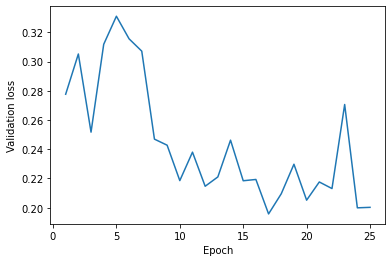

Validation accuracy v/s epoch plot: 


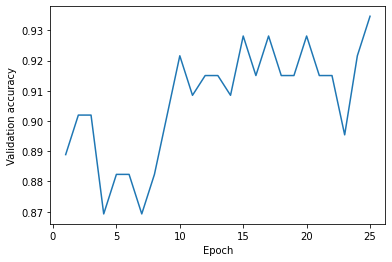

Epoch 0/24
----------
train Loss: 0.6573 Acc: 0.6926
val Loss: 0.2483 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4186 Acc: 0.8238
val Loss: 0.6422 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.4748 Acc: 0.7828
val Loss: 0.1532 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4675 Acc: 0.8361
val Loss: 0.2288 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5033 Acc: 0.7746
val Loss: 0.4523 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.6359 Acc: 0.7541
val Loss: 0.3710 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.6883 Acc: 0.7459
val Loss: 0.2988 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.2850 Acc: 0.8648
val Loss: 0.2608 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3416 Acc: 0.8689
val Loss: 0.2478 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2110 Acc: 0.8934
val Loss: 0.2590 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3383 Acc: 0.8730
val Loss: 0.2539 Acc: 0.8824

Epoch 11/24
----------
train Loss: 0.3911 Acc: 0.8238
val Loss: 0.2424 Acc: 0.9020

Ep

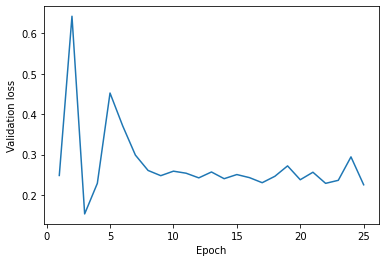

Validation accuracy v/s epoch plot: 


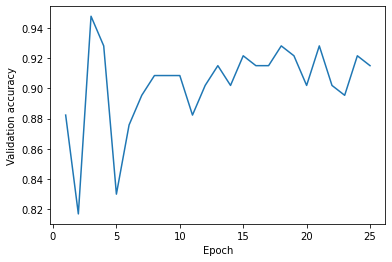

Epoch 0/24
----------
train Loss: 0.5882 Acc: 0.7008
val Loss: 0.5225 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.4634 Acc: 0.8115
val Loss: 0.2239 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4897 Acc: 0.7869
val Loss: 0.3717 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.6851 Acc: 0.7418
val Loss: 0.2097 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5903 Acc: 0.7828
val Loss: 0.4119 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.4630 Acc: 0.7992
val Loss: 0.2763 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3417 Acc: 0.8525
val Loss: 0.2416 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4058 Acc: 0.8279
val Loss: 0.2176 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3867 Acc: 0.8484
val Loss: 0.2170 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4502 Acc: 0.8320
val Loss: 0.2803 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.2813 Acc: 0.8566
val Loss: 0.2909 Acc: 0.8824

Epoch 11/24
----------
train Loss: 0.2012 Acc: 0.9262
val Loss: 0.2131 Acc: 0.9216

Ep

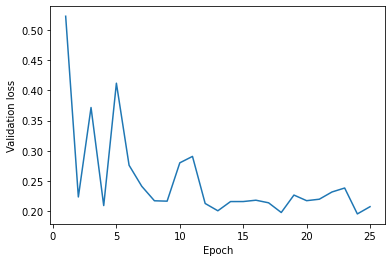

Validation accuracy v/s epoch plot: 


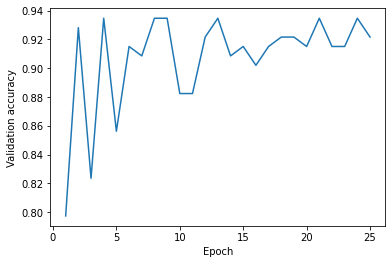

Epoch 0/24
----------
train Loss: 0.6022 Acc: 0.7172
val Loss: 0.1593 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4000 Acc: 0.8033
val Loss: 0.2625 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4135 Acc: 0.8402
val Loss: 0.1770 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5176 Acc: 0.7828
val Loss: 0.3316 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5285 Acc: 0.8033
val Loss: 0.3872 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.5094 Acc: 0.7992
val Loss: 0.2680 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3795 Acc: 0.8770
val Loss: 0.3226 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4291 Acc: 0.8402
val Loss: 0.2857 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3195 Acc: 0.8566
val Loss: 0.2438 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3037 Acc: 0.8607
val Loss: 0.2312 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3753 Acc: 0.8402
val Loss: 0.2185 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3098 Acc: 0.8689
val Loss: 0.2210 Acc: 0.9281

Ep

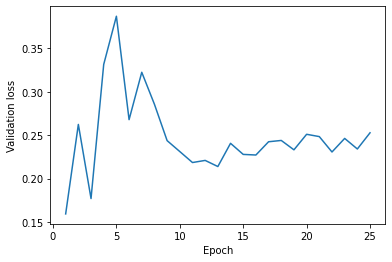

Validation accuracy v/s epoch plot: 


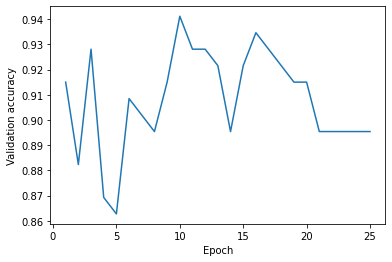

Epoch 0/24
----------
train Loss: 0.4888 Acc: 0.7336
val Loss: 0.2995 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4448 Acc: 0.8074
val Loss: 0.3487 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4715 Acc: 0.8074
val Loss: 0.2942 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4453 Acc: 0.8238
val Loss: 0.2464 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.6074 Acc: 0.7418
val Loss: 0.4872 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.6930 Acc: 0.7869
val Loss: 0.2713 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4882 Acc: 0.7869
val Loss: 0.3116 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4679 Acc: 0.8320
val Loss: 0.2645 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3576 Acc: 0.8607
val Loss: 0.2380 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3237 Acc: 0.8320
val Loss: 0.2220 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2586 Acc: 0.8893
val Loss: 0.2206 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3622 Acc: 0.8484
val Loss: 0.2174 Acc: 0.9346

Ep

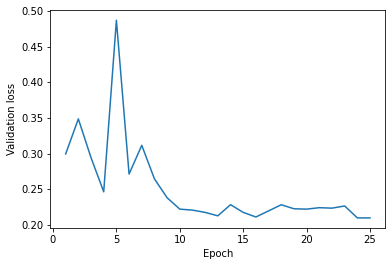

Validation accuracy v/s epoch plot: 


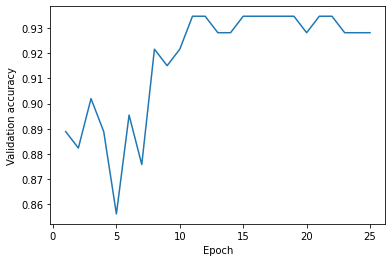

In [20]:
from matplotlib.patches import Wedge
Weight_decays = [0.1,0.01,0.001,0.0001,0.00001] # Defining a list of weight decays for checking for the best weight decay
for w in Weight_decays:
  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  model_ft.fc = nn.Linear(num_ftrs, 2)

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(),weight_decay=w, lr=0.001, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

For weight decay = 0.1, validation accuracy increases but that increased accuracy is also not that much efficient in comparison to the accuracies in other weight decays. for weight decay = 0.01, the best validation accuracy slightly increases. and it converges fastly for weight decay = 0.01 . For weight decay = 0.001, the behaviour is almost same as for 0.1 .

For 0.0001, there is no improvement in the model accuracy. And 0.00001 also doesn't have much accuracy, but it seems to be saturated at that validation accuracy level and just keeps oscillating around 93 %. So, weight decays 0.001 and 0.00001 are good for the model.

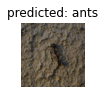

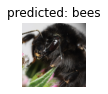

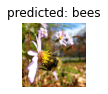

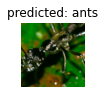

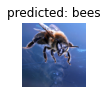

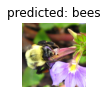

In [21]:
visualize_model(model_ft)

Discussed with:
1. Rupesh Yadav(21i190004)
2. Abhishek Gupta(21i190005)

References:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/docs/stable/optim.html

